# Question -duplicate data using sklearn and RNN

In [ ]:
path = "/content/drive/MyDrive/datasets/zip data files/quora_duplicate_questions.tsv"
datasets = pd.read_csv(path,sep="\t", header=0)

# datasets[['question1','question2']]=  datasets.select_dtypes(include='O').convert_dtypes(pd.StringDtype())

datasets.dropna(inplace=True)
train_dataset,valid_dataset  = datasets.iloc[:int(datasets.shape[0]*0.8),:],datasets.iloc[int(datasets.shape[0]*0.8):,:]
datasets.to_csv("/content/csv_quora_data.csv")

train_dataset.to_csv("/content/csv_quora_data_train.csv")
valid_dataset.to_csv("/content/csv_quora_data_valid.csv")
datasets.head(1)
datasets.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 404348 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404348 non-null  int64 
 1   qid1          404348 non-null  int64 
 2   qid2          404348 non-null  int64 
 3   question1     404348 non-null  object
 4   question2     404348 non-null  object
 5   is_duplicate  404348 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [ ]:
train_dataset.shape,valid_dataset.shape

((323478, 6), (80870, 6))

In [ ]:
tf_datasets = tf.data.experimental.CsvDataset("/content/csv_quora_data.csv", [tf.int32, tf.int32, tf.string,tf.string,tf.int32],header=True, select_cols=[2,3,4,5,6])
tf_datasets


<CsvDatasetV2 shapes: ((), (), (), (), ()), types: (tf.int32, tf.int32, tf.string, tf.string, tf.int32)>

In [ ]:
train_tf_datasets = tf.data.experimental.CsvDataset("/content/csv_quora_data_train.csv", [tf.string,tf.string,tf.int32],header=True, select_cols=[4,5,6])
valid_tf_datasets = tf.data.experimental.CsvDataset("/content/csv_quora_data_valid.csv", [tf.string,tf.string,tf.int32],header=True, select_cols=[4,5,6])
train_tf_datasets;  valid_tf_datasets

<CsvDatasetV2 shapes: ((), (), ()), types: (tf.string, tf.string, tf.int32)>

In [ ]:
import regex as re
pat = re.compile("[.!@#$%^&*()><:;""''?/\*0-9]")

def tf_preprocess(input_data):
    input_data =input_data.map(lambda c,d,x: (tf.strings.lower(c),tf.strings.lower(d),x))
    data = input_data.map(lambda a,c,d: (tf.strings.regex_replace(a,"[.!@#$%^&*()><:;""''?/\*0-9]",""),tf.strings.regex_replace(c,"[.!@#$%^&*()><:;""''?/\*0-9]",""),d))
    data = data.cache().shuffle(10**5).batch(64).prefetch(1)
    return data

# datasets.dropna(inplace=True)
# datasets['question1'] = datasets['question1'].apply(preprocess)
# datasets['question2'] = datasets['question2'].apply(preprocess)


tf_datasets= tf_datasets.apply(tf_preprocess)

train_tf_datasets= train_tf_datasets.apply(tf_preprocess);  valid_tf_datasets = valid_tf_datasets.apply(tf_preprocess)


In [ ]:

def spliting_data():
    datasets_valid = datasets.iloc[:int(0.2*datasets.shape[0]),:]
    datasets_train = datasets.iloc[int(0.2*datasets.shape[0]):,:]
    return datasets_train,datasets_valid
datasets_train,datasets_valid = spliting_data()



In [ ]:
# files saving for keras data preprocessing
path0 ="/content/drive/MyDrive/train_quora/0/train0.csv"
path1 ="/content/drive/MyDrive/train_quora/1/train1.csv"

datasets_train[datasets_train['is_duplicate']==0].to_csv(path0)
datasets_train[datasets_train['is_duplicate']==1].to_csv(path1)

path0 ="/content/drive/MyDrive/validation_qoura/0/valid0.csv"
path1 ="/content/drive/MyDrive/validation_qoura/1/valid1.csv"

datasets_valid[datasets_valid['is_duplicate']==0].to_csv(path0)
datasets_valid[datasets_valid['is_duplicate']==1].to_csv(path1)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def pd_to_tensor():
    d = datasets['question1']
    df2 = tf.ragged.constant(d,dtype=tf.string)
    df = tf.ragged.constant(datasets['question2'],dtype=tf.string)

    datasets['question1'] = df2
    datasets['question2'] = df
    return datasets
datasets = pd_to_tensor()


In [ ]:
tf_text_dataset = tf_datasets.map(lambda qid1,qid2,y: ((qid1,qid2),y))
tf_text_dataset= tf_text_dataset.cache().shuffle(10**5).prefetch(1)

valid_tf_dataset = valid_tf_datasets.map(lambda qid1,qid2,y: ((qid1,qid2),y))
valid_tf_dataset = valid_tf_dataset.cache().shuffle(10**5).prefetch(1)

train_tf_dataset = train_tf_datasets.map(lambda qid1,qid2,y: ((qid1,qid2),y))
train_tf_dataset = train_tf_dataset.cache().shuffle(10**5).prefetch(1)


tf_text_new = tf_datasets.map(lambda qid1, qid2,y: (qid1))
tf_text_new = tf_text_new.cache().prefetch(1)

tf_text_new2 = tf_datasets.map(lambda qid1, qid2,y: (qid2))
tf_text_new2 = tf_text_new2.cache().prefetch(1)


In [ ]:
text_df = tf_text_new.concatenate(tf_text_new2)
text_df = text_df.cache().prefetch(1)




In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(text_df.map(lambda text: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
for example, label in tf_text_dataset.take(1):
    print("text:", example[0][0], example[1][0])
    print()
    print("label:",label[0])
encoded_example = encoder(example[0])[:3].numpy()
encoded_example.shape

text: tf.Tensor(b'what does right side chest pain indicate', shape=(), dtype=string) tf.Tensor(b'why is the right side of the chest is paining', shape=(), dtype=string)

label: tf.Tensor(1, shape=(), dtype=int32)


(3, 24)

In [ ]:
for n in range(3):
  print("Original: ", example[1][n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

# (encoded_example).shape

Original:  b'why is the right side of the chest is paining'
Round-trip:  what does right side [UNK] pain [UNK]                 

Original:  b'what are burlap tablecloths made of'
Round-trip:  how can i [UNK] [UNK] [UNK]                  

Original:  b'why do some people on quora edit questions to the point the original question or important details are lost'
Round-trip:  why can everyone [UNK] my questions on quora to anything even for [UNK]           



In [ ]:
model = keras.Sequential([
                          encoder,
                          keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),mask_zero=True,output_dim=64
                                                 ),
                          keras.layers.Bidirectional(keras.layers.LSTM(64)),
                          keras.layers.Dense(64,activation="relu"),
                          keras.layers.Dense(1)
])

print([layer.supports_masking for layer in model.layers])


sample_text = ('what is name president'
                'how do I become seo expert' )
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[False, True, True, True, True]
[0.00177471]
[0.00177471]


In [ ]:
tf_text_dataset.map(lambda x)

<bound method DatasetV2.map of <PrefetchDataset shapes: (((None,), (None,)), (None,)), types: ((tf.string, tf.string), tf.int32)>>

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(tf_text_dataset, epochs=10,
                    # validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
6318/6318 [==============================] - 94s 14ms/step - loss: 0.5653 - accuracy: 0.6996
Epoch 2/10
6318/6318 [==============================] - 87s 14ms/step - loss: 0.5498 - accuracy: 0.7121
Epoch 3/10
6318/6318 [==============================] - 87s 14ms/step - loss: 0.5441 - accuracy: 0.7153
Epoch 4/10
6318/6318 [==============================] - 86s 14ms/step - loss: 0.5400 - accuracy: 0.7175
Epoch 5/10
6318/6318 [==============================] - 86s 14ms/step - loss: 0.5362 - accuracy: 0.7201
Epoch 6/10
6318/6318 [==============================] - 86s 14ms/step - loss: 0.5328 - accuracy: 0.7222
Epoch 7/10
6318/6318 [==============================] - 86s 14ms/step - loss: 0.5296 - accuracy: 0.7240
Epoch 8/10
6318/6318 [==============================] - 86s 14ms/step - loss: 0.5267 - accuracy: 0.7258
Epoch 9/10
6318/6318 [==============================] - 85

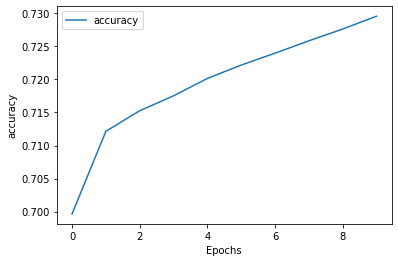

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
#   plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plot_graphs(history,'accuracy')

In [ ]:
model.evaluate(valid_tf_dataset)

Consider rewriting this model with the Functional API.
1264/1264 [==============================] - 12s 6ms/step - loss: 0.5124 - accuracy: 0.7364


[0.5124017596244812, 0.7364411950111389]

In [ ]:
for (text1,text2),label in valid_tf_dataset.take(1):
    print(len(text1), label.shape)
    print(text1[0], text2[0], label[0])

64 (64,)
tf.Tensor(b'how has stephen hawking survived with als for so long', shape=(), dtype=string) tf.Tensor(b'how does stephen hawking laugh', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
np.argmax(model.predict((text1,text2)), axis=-1), label
m1 = model.predict_classes((text1,text2)).reshape(1,-1)[0]; m2 = label

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# sns.lineplot(x = np.arange(m1[0].shape[1]), y=m1[0])
mean_squared_error(m2.numpy(),m1)
# m1.shape,m2.shape

m2.numpy(),m1

(array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       dtype=int32),
 array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       dtype=int32))